In [1]:
# Load Libraries
import os
import PIL
import numpy as np
import torch
import glob
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam,SGD
from torch.optim import lr_scheduler

from torch.autograd import Variable
import torchvision
import pathlib
from torchvision import datasets, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import time

from torchsummary import summary

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cuda


In [5]:
#Transforms for data processing
transformer = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1 and numpy to tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
image_datasets = datasets.ImageFolder('/Users/jiaulhaquesaboj/Documents/Deep-Learning-Project/Garbage Classification', transformer)
print(len(image_datasets))

class_names = image_datasets.classes
print(class_names)

15515
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [7]:
datasets = {}
train_idx, val_idx = train_test_split(list(range(len(image_datasets))), test_size=0.2)
val_path = torch.utils.data.Subset(image_datasets, val_idx)
train_set = torch.utils.data.Subset(image_datasets, train_idx)
train_path = torch.utils.data.Subset(image_datasets, train_idx)
print(len(train_path))
print(len(val_path))


12412
3103


In [8]:
train_loader = DataLoader(
    train_path,
    batch_size = 128, shuffle = True
    
)
val_loader = DataLoader(
    val_path,
    batch_size = 128,
    shuffle = True
)

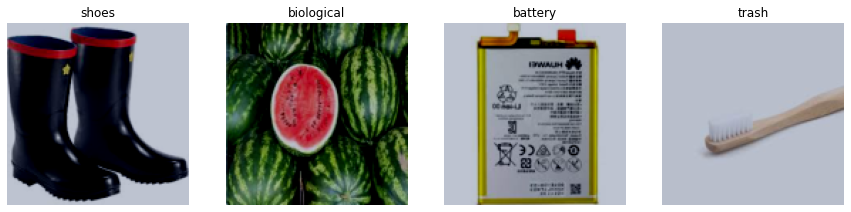

In [9]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imgs = images[i].numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + std
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.axis('off')
    plt.title(class_names[labels[i]])

In [10]:
class_names = image_datasets.classes
print(class_names)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [11]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=12):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (3,128,128), Output shape= (32,128,128)
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        #Input shape= (32,128,128), Output shape= (32,64,64)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        
        #Input shape= (32,64,64), Output shape= (64,64,64)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        #Input shape= (64,64,64), Output shape= (64,32,32)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        
        #Input shape= (64,32,32), Output shape= (64,32,32)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,bias=False)
        self.relu3=nn.ReLU()
        #Input shape= (64,32,32), Output shape= (64,16,16)
        self.pool3=nn.MaxPool2d(kernel_size=2)
        
        
        #Input shape= (64,16,16), Output shape= (64,16,16)
        self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,bias=False)
        self.relu4=nn.ReLU()
        #Input shape= (64,32,32), Output shape= (64,8,8)
        self.pool4=nn.MaxPool2d(kernel_size=2)
        
#         #Input shape= (64,8,8), Output shape= (64,8,8)
#         self.conv5=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)
#         self.relu5=nn.ReLU()
#         #Input shape= (64,8,8), Output shape= (64,4,4)
#         self.pool5=nn.MaxPool2d(kernel_size=2)
        
        
        self.fc1 = nn.Linear(in_features=64*8*8,out_features=256)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.relu7 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=128,out_features=num_classes)

        
        

        
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.pool1(output)
            
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.pool2(output)
            
        output=self.conv3(output)
        output=self.relu3(output)
        output=self.pool3(output)
        
        output=self.conv4(output)
        output=self.relu4(output)
        output=self.pool4(output)
            
#         output=self.conv5(output)
#         output=self.relu5(output)
#         output=self.pool5(output)
        
         #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,64*8*8)
        
            
            
        output=self.fc1(output)
        output=self.relu6(output)
        output=self.fc2(output)
        output=self.relu7(output)
        output=self.fc3(output)

            
        return output

In [12]:
model = ConvNet(num_classes=12).to(device)

In [13]:
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,432
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,864
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Linear-13                  [-1, 256]       1,048,832
             ReLU-14                  [

In [14]:
#Optimizer and Loss function
optimizer=Adam(model.parameters(), lr=0.001)
loss_function=nn.CrossEntropyLoss()

In [15]:
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)

In [16]:
num_epochs=10

In [17]:
torch.cuda.empty_cache()

In [18]:
#Model training and saving best model
def train_model(model, loss_function, optimizer, num_epochs):
    train_start = time.time()
    history = []
    val_history = []
#--------------------------------------------------------------------
    best_accuracy=0.0

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        #Evaluation and training on training dataset
        epoch_start = time.time()
        model.train()
        train_accuracy=0.0
        train_loss=0.0
        val_accuracy=0.0
        val_loss=0.0

        for i, (images,labels) in enumerate(train_loader):
            torch.cuda.empty_cache()
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()


            outputs=model(images)

            loss=loss_function(outputs,labels)
            
            
#             L1 Regularization
#             l1_crit = nn.L1Loss(size_average=False)
#             reg_loss = 0
#             for param in model.parameters():
#                 reg_loss += l1_crit(param,target=torch.zeros_like(param))

#             factor = 0.00005
#             loss += factor * reg_loss
            
            
            
            loss.backward()
            optimizer.step()


            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/len(train_path)
        train_loss=train_loss/len(train_path)
        
        history.append([train_loss, train_accuracy])
        
        
        model.eval()



        for i, (images,labels) in enumerate(val_loader):
            torch.cuda.empty_cache()
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            loss = loss_function(outputs,labels)
            _,prediction=torch.max(outputs.data,1)
            val_loss+= loss.cpu().data*images.size(0)
            val_accuracy+=int(torch.sum(prediction==labels.data))
        
        val_accuracy=val_accuracy/len(val_path)
        val_loss=val_loss/len(val_path)
        
        val_history.append([val_loss,val_accuracy])


        print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+"\n\t Val Loss: "+str(val_loss)+" Val Accuracy: " + str(val_accuracy)+  ' Time: '+str(time.time()-epoch_start))
    return model, history,val_history 
        #Save the best model
#         if test_accuracy>best_accuracy:
#             torch.save(model.state_dict(),'best_checkpoint.model')
#             best_accuracy=test_accuracy

In [19]:
trained_model, history, val_history = train_model(model, loss_function, optimizer, num_epochs)

Epoch: 1 Train Loss: tensor(1.4588) Train Accuracy: 0.5232839187882694
	 Val Loss: tensor(1.1828) Val Accuracy: 0.6068320979697067 Time: 373.5106723308563
Epoch: 2 Train Loss: tensor(1.0243) Train Accuracy: 0.66185949081534
	 Val Loss: tensor(0.9687) Val Accuracy: 0.6748308088946181 Time: 130.86483120918274
Epoch: 3 Train Loss: tensor(0.8540) Train Accuracy: 0.7169674508540123
	 Val Loss: tensor(0.8785) Val Accuracy: 0.7164034805027393 Time: 54.67432427406311
Epoch: 4 Train Loss: tensor(0.7305) Train Accuracy: 0.7572510473735095
	 Val Loss: tensor(0.8374) Val Accuracy: 0.7318723815662262 Time: 54.94487762451172
Epoch: 5 Train Loss: tensor(0.6366) Train Accuracy: 0.7918143731872381
	 Val Loss: tensor(0.7520) Val Accuracy: 0.7657106026426039 Time: 54.35032892227173
Epoch: 6 Train Loss: tensor(0.5459) Train Accuracy: 0.8217048018047052
	 Val Loss: tensor(0.7071) Val Accuracy: 0.7728005156300355 Time: 53.977890729904175
Epoch: 7 Train Loss: tensor(0.5010) Train Accuracy: 0.8347566870770222

In [20]:
train_loss = [h[0] for h in history]
train_acc = [h[1] for h in history]

val_loss = [v[0] for v in val_history]
val_acc = [v[1] for v in val_history]

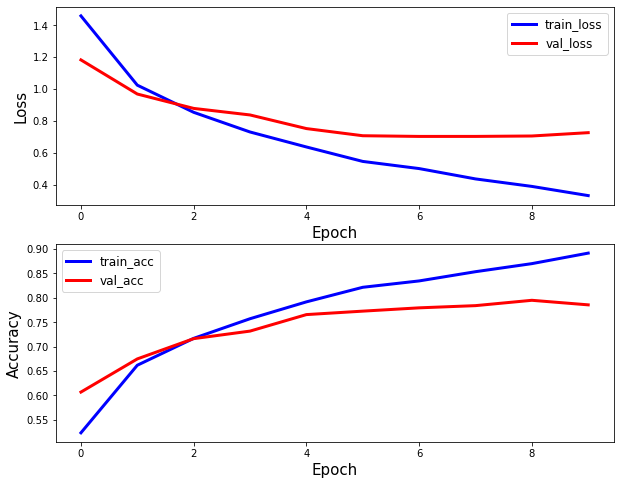

In [21]:
def plot_model_history(history,val_accuracy):
    x = np.arange(len(history))
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label='train_loss', lw=3, c="b")
    plt.plot(x, val_loss, label='val_loss', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.subplot(2, 1, 2)
    plt.plot(x, train_acc, label='train_acc', lw=3, c="b")
    plt.plot(x, val_acc, label='val_acc', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.show()

plot_model_history(history,val_history)